In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

Appending key for api.wandb.ai to your netrc file: /Users/guydavidson/.netrc
Successfully logged in to Weights & Biases!


In [3]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath

import pickle
import tabulate
import wandb

In [4]:
np.set_printoptions(linewidth=100)

In [159]:
MIN_FONT_SIZE = 16
LABELS_FONT_SIZE = 20

matplotlib.rcParams.update({'font.size': MIN_FONT_SIZE})
FONT_DICT = dict(fontsize=LABELS_FONT_SIZE) 

## Fetch the relevant runs from WandB

In [24]:
FULL_DATASET_PATTERN = 'meta-learning-scaling/sequential-benchmark/{run_id}'
FULL_DATASET_RUN_IDS = ('xk3ic9p7', 'lgkb14dn', '43wf5c4j', 'qq4mewef', 'i8o9tns8')


api = wandb.Api()
histories = [api.run(FULL_DATASET_PATTERN.format(run_id=run_id)).history(pandas=True)
             for run_id in FULL_DATASET_RUN_IDS]


In [25]:
print(histories[0].shape)
histories[0][:10]

(141, 95)


,Test AUC,Test Accuracy,Test Loss,Test Per-Query Accuracy (dict).0,Test Per-Query Accuracy (dict).1,Test Per-Query Accuracy (dict).10,Test Per-Query Accuracy (dict).11,Test Per-Query Accuracy (dict).12,Test Per-Query Accuracy (dict).13,Test Per-Query Accuracy (dict).14,...,gradients/fc1.bias,gradients/fc1.weight,gradients/fcout.fc2.bias,gradients/fcout.fc2.weight,gradients/fcout.fc3.bias,gradients/fcout.fc3.weight,gradients/fcout.fc4.bias,gradients/fcout.fc4.weight,gradients/fcout.fc5.bias,gradients/fcout.fc5.weight
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'_type': 'histogram', 'values': [4, 0, 3, 2, ...","{'bins': [-0.0007078171474859118, -0.000686200...","{'bins': [-3.4073571441695094e-05, -3.06374058...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [3, 1, 3, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 1, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [2, 1, 0, 0, ..."
1,0.516887,54.79,0.684010,0.5378,0.5654,0.4910,0.5188,0.4758,0.5030,0.5780,...,"{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'bins': [-0.006817657500505447, -0.0066224099...","{'bins': [-0.0019140464719384909, -0.001858757...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'values': [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 2...","{'values': [1, 2, 1, 0, 2, 0, 1, 7, 9, 9, 16, ...","{'_type': 'histogram', 'values': [1, 2, 0, 0, ...","{'_type': 'histogram', 'values': [1, 3, 3, 2, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 2, 1, ..."
2,0.518163,55.52,0.685925,0.5464,0.5624,0.5068,0.5408,0.4944,0.5010,0.5946,...,"{'bins': [-0.02490227483212948, -0.02411620505...","{'_type': 'histogram', 'values': [4, 3, 3, 2, ...","{'_type': 'histogram', 'values': [2, 1, 1, 1, ...","{'bins': [-0.036345042288303375, -0.0345625244...","{'values': [1, 1, 1, 4, 4, 2, 6, 0, 1, 0, 1, 2...","{'bins': [-0.008250974118709564, -0.0079305432...","{'_type': 'histogram', 'values': [3, 1, 5, 4, ...","{'_type': 'histogram', 'values': [1, 1, 3, 4, ...","{'bins': [-0.0384378507733345, -0.037236668169...","{'_type': 'histogram', 'values': [3, 1, 4, 8, ..."
3,0.571805,59.56,0.628058,0.5462,0.5568,0.5328,0.6620,0.5964,0.5796,0.5980,...,"{'values': [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0...","{'bins': [-0.03510168194770813, -0.03343043848...","{'_type': 'histogram', 'values': [2, 0, 0, 0, ...","{'_type': 'histogram', 'values': [2, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 1, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [4, 1, 3, 8, ..."
4,0.595458,61.67,0.597502,0.5510,0.5526,0.6360,0.6840,0.6100,0.5914,0.9514,...,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 1, 0, ...","{'_type': 'histogram', 'values': [1, 2, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 2, 1, 1, ...","{'_type': 'histogram', 'values': [8, 0, 0, 0, ...","{'_type': 'histogram', 'values': [2, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 1, 2, ..."
5,0.635470,64.14,0.559530,0.5428,0.5494,0.9172,0.6850,0.6392,0.5960,0.9806,...,"{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [2, 0, 1, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 1, 3, 2, ...","{'bins': [-0.020014390349388123, -0.0194889325...","{'bins': [-0.00407235324382782, -0.00396479154...","{'_type': 'histogram

## Plot the test accuracy and AUC for these models

In [179]:
NAMES = ('No query modulation', 'Modlation level 1', 'Modlation level 2', 'Modlation level 3', 'Modlation level 4')

PER_PLOT_WIDTH = 8

def multiple_comparison_plot(keys, titles, super_title, 
                             start_index=0, x_start=0, compute_x_max=False, font_dict=None):
    font = FONT_DICT.copy()
    if font_dict is not None:
        font.update(font_dict)
    font_dict = font
    
    plt.figure(figsize=(PER_PLOT_WIDTH * len(keys), 6))
    plt.subplots_adjust(top=0.825, hspace=0.25, wspace=0.2)
    plt.suptitle(super_title, fontsize=font_dict['fontsize'] * 1.5)
        
    x_max = None
    if compute_x_max:
        x_max = np.min([len(history[keys[0]]) for history in histories])
    
    for index, (key, title) in enumerate(zip(keys, titles)):
        ax = plt.subplot(1, len(keys), index + 1)
    
        for name, history in zip(NAMES[start_index:], histories[start_index:]):
            y_values = history[key][x_start:x_max]
            x_values = np.arange(len(y_values)) + x_start
            ax.plot(x_values, y_values, label=name)

        ax.legend(loc='best', **font_dict)
        ax.set_xlabel('Epoch', **font_dict)
        ax.set_ylabel(key, **font_dict)
        ax.set_title(title)
        
    plt.show()



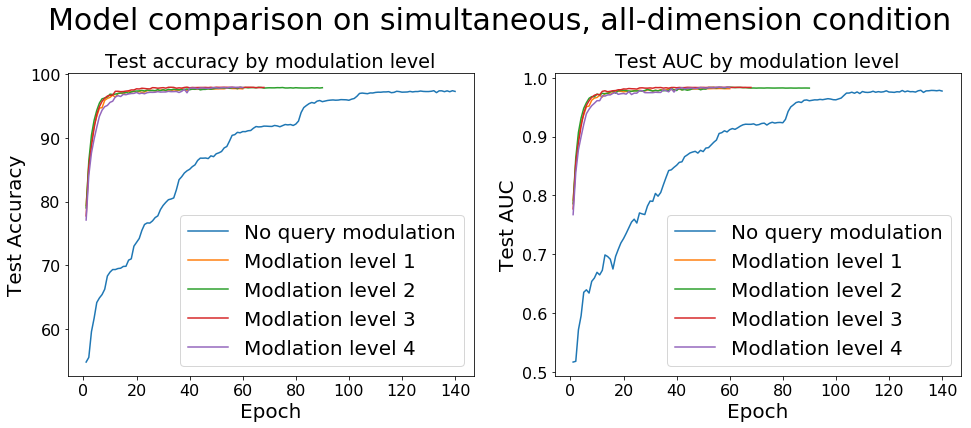

In [180]:
multiple_comparison_plot(('Test Accuracy', 'Test AUC'), 
                ('Test accuracy by modulation level', 'Test AUC by modulation level'),
                'Model comparison on simultaneous, all-dimension condition')


Looks like these models all learn much faster than the baseline model, but don't actually peak at a higher accuracy. Let's focus only on them to see if we can learn much:

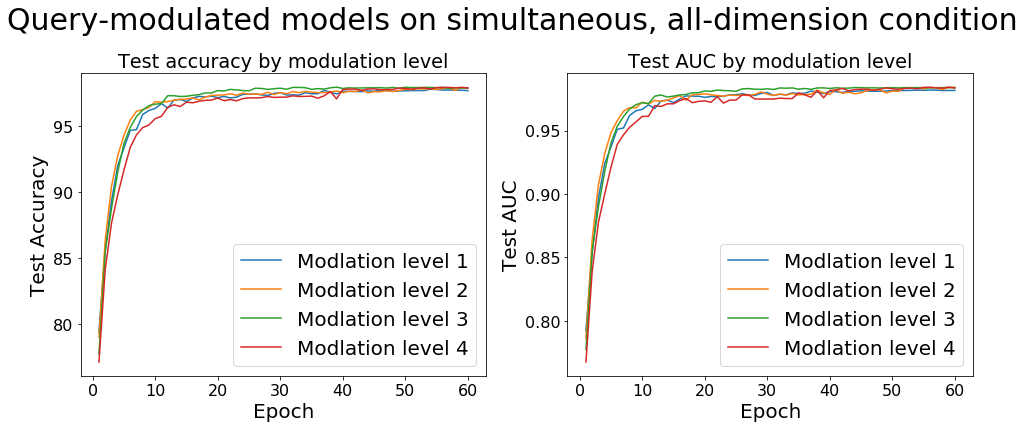

In [181]:
multiple_comparison_plot(('Test Accuracy', 'Test AUC'), 
                         ('Test accuracy by modulation level', 'Test AUC by modulation level'),
                         'Query-modulated models on simultaneous, all-dimension condition',
                         1, 0, True)


Looks like the third modulation level is a little bit better, but let's zoom in a little bit:

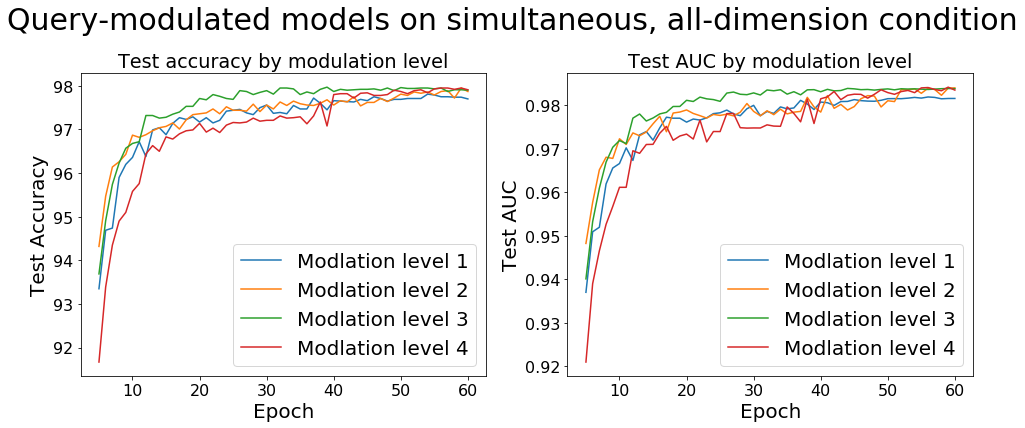

In [182]:
multiple_comparison_plot(('Test Accuracy', 'Test AUC'), 
                         ('Test accuracy by modulation level', 'Test AUC by modulation level'),
                         'Query-modulated models on simultaneous, all-dimension condition',
                         1, 5, True)


## Plotting accuracy by dimension, for each modulation level

In [210]:
QUERY_NAMES = ['blue', 'brown', 'cyan', 'gray', 'green', 'orange', 'pink',
               'purple', 'red', 'yellow', 'cone', 'cube', 'cylinder',
               'dodecahedron', 'ellipsoid', 'octahedron', 'pyramid', 'rectangle',
               'sphere', 'torus', 'chain_mail', 'marble', 'maze', 'metal',
               'metal_weave', 'polka', 'rubber', 'rug', 'tiles', 'wood_plank']
DIMENSION_NAMES = ['color', 'shape', 'texture']
KEY_TEMPLATE = 'Test Per-Query Accuracy (dict).{task_id}'

COLORS = dict(gray=(0.3411764705882353, 0.3411764705882353, 0.3411764705882353),
              red=(0.6784313725490196, 0.13725490196078433, 0.13725490196078433),
              blue=(0.16470588235294117, 0.29411764705882354, 0.8431372549019608),
              green=(0.11372549019607843, 0.4117647058823529, 0.0784313725490196),
              brown=(0.5058823529411764, 0.2901960784313726, 0.09803921568627451),
              purple=(0.5058823529411764, 0.14901960784313725, 0.7529411764705882),
              cyan=(0.1607843137254902, 0.8156862745098039, 0.8156862745098039),
              yellow=(1.0, 0.9333333333333333, 0.2),
              orange=(1.0, 0.5725490196078431, 0.2),
              pink=(1.0, 0.803921568627451, 0.9529411764705882))

In [225]:
NROWS = 5
NCOLS = 3

PER_COL_WIDTH = 6
PER_ROW_HEIGHT = 5

def plot_accuracy_by_dimension(histories, font_dict=None, ylim=None,
                               x_start=0, compute_x_max=False, colors=None):
    plt.figure(figsize=(NCOLS * PER_COL_WIDTH, NROWS * PER_ROW_HEIGHT))
    plt.subplots_adjust(top=0.95, hspace=0.2, wspace=0.15)
    
    font = FONT_DICT.copy()
    if font_dict is not None:
        font.update(font_dict)
    font_dict = font
    
    for model_index, history in enumerate(histories):
        for dimension_index, dimension_name in enumerate(DIMENSION_NAMES):
            ax = plt.subplot(NROWS, NCOLS, model_index * NCOLS + dimension_index + 1)

            title = None
            if model_index == 0:
                title = dimension_name.capitalize()
                
            x_label = None
            if model_index == NROWS - 1:
                x_label = 'Epoch'
                
            y_label = None
            if dimension_index == 0:
                if model_index == 0:
                    y_label = f'No query\nmodulation'
                else:
                    y_label = f'Query modulation\nat conv-{model_index}'
                
                
            single_model_single_dimension_plot(ax, history,
                                               10 * dimension_index, 
                                               10 * (dimension_index + 1), 
                                               x_start, ylim, title, x_label, y_label, 
                                               font_dict, colors)
            
    plt.suptitle('Accuracy per dimension by modulation level', fontsize=font_dict['fontsize'] * 1.5)
    plt.show()
    
    
def single_model_single_dimension_plot(ax, history,
                                       start_task, end_task, x_start=0, ylim=None,
                                        title=None, x_label=None, y_label=None,
                                          font_dict=None, colors=None):
    font = FONT_DICT.copy()
    if font_dict is not None:
        font.update(font_dict)
    font_dict = font
    
    sample_y_values = history[KEY_TEMPLATE.format(task_id=start_task)][x_start:]
    x_values = np.arange(len(sample_y_values)) + x_start
    
    for index, task_id in enumerate(range(start_task, end_task)):
        color = None
        if colors is not None:
            if isinstance (colors, dict):
                color = colors[QUERY_NAMES[index % 10]]
            else:
                color = colors[index / 10]
        
        ax.plot(x_values, history[KEY_TEMPLATE.format(task_id=task_id)][x_start:],
                label=QUERY_NAMES[task_id], color=color, alpha=0.8)
    
    if ylim is not None:
        ax.set_ylim(ylim)
    
    legend_fontsize = font_dict['fontsize'] - 8
    ax.legend(loc='lower right', fontsize=legend_fontsize)
    if x_label is not None:
        ax.set_xlabel(x_label, **font_dict)
    if y_label is not None:
        ax.set_ylabel(y_label, **font_dict)
    if title is not None:
        ax.set_title(title, **font_dict)

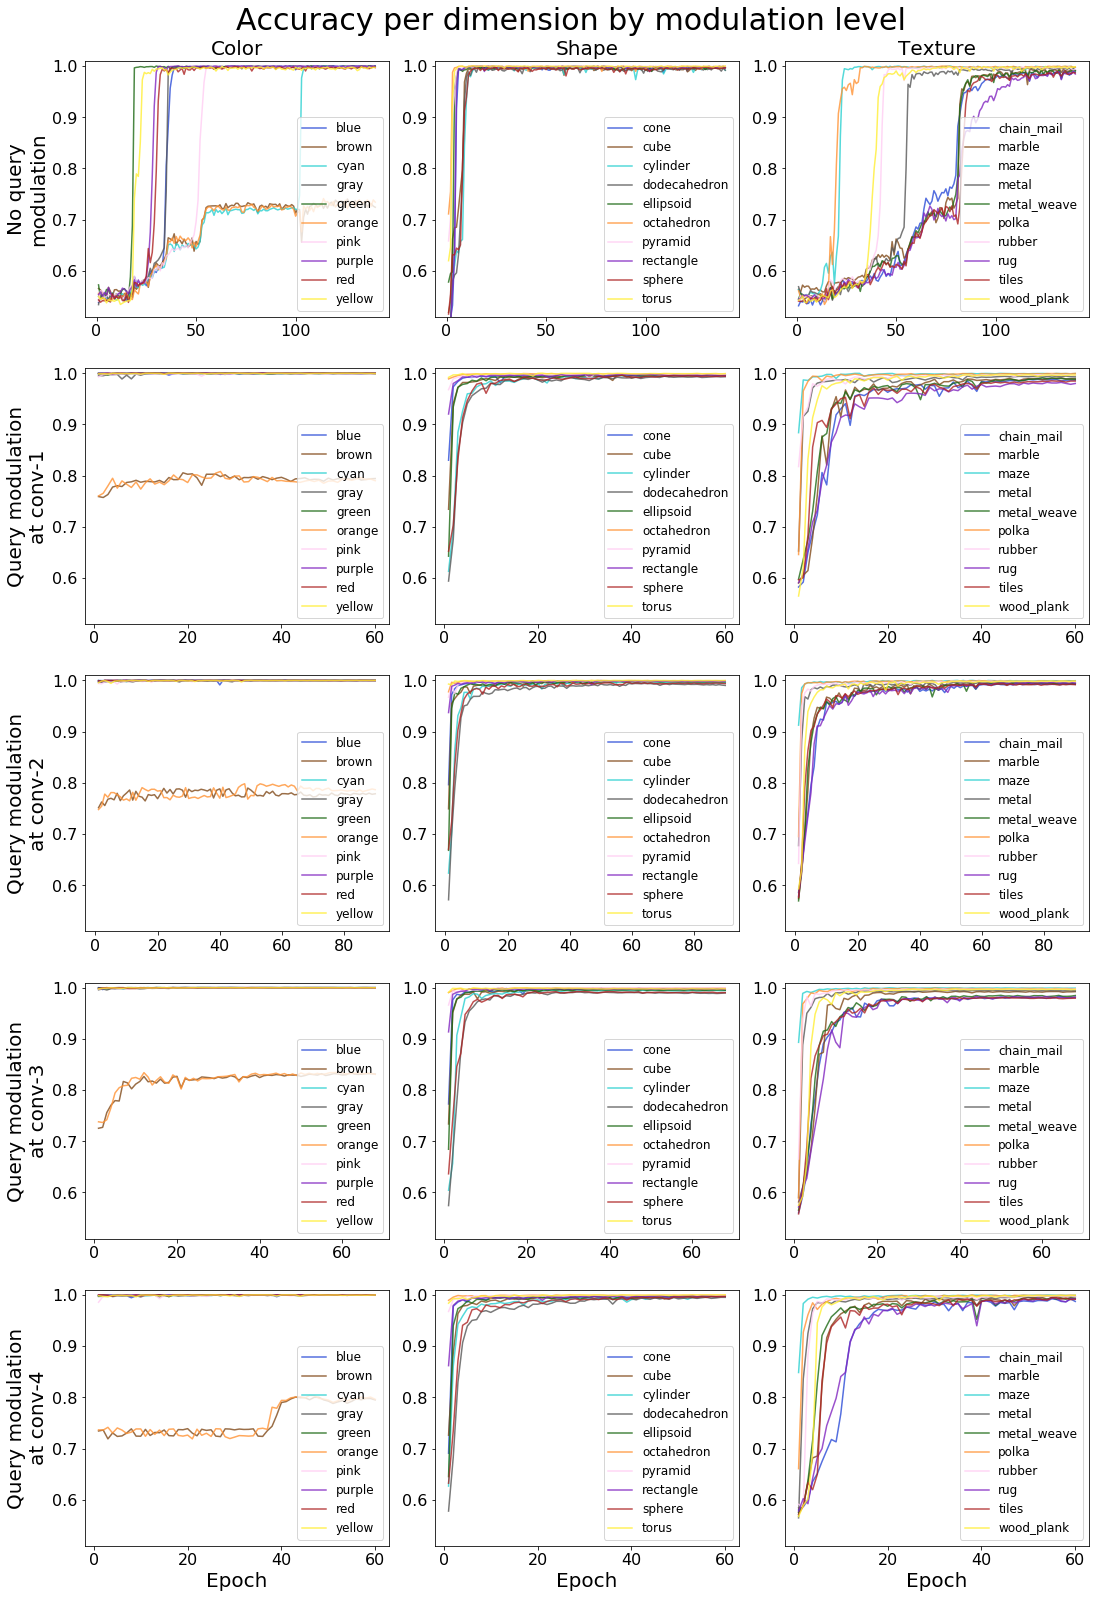

In [228]:
ylim = (0.51, 1.01)
plot_accuracy_by_dimension(histories, ylim=ylim, colors=COLORS)